# Classification Code

Code for classifying videos based on emotions present, and present the results. 
Note that most of this code is now in the server code (classify_video.py and classify_image.py), as my local machine did not have the power to process the videos quickly. At the end of this notebook is the code I used to display results from the server.



In [2]:
from tensorflow.keras.models import load_model
from collections import deque
import numpy as np
from sklearn.preprocessing import LabelBinarizer
import argparse
import pickle
import cv2
import glob
import re
from sklearn.metrics import classification_report

Set out the parameters of the classification to perform

In [2]:
MODEL = "fer-vgg"

# One of ravdess, ravdess-faces
DATASET = "ravdess-faces"
FOUR_EMOTIONS = False

if MODEL == "RN50":
    model = load_model('../models/best-models/resnet50.h5')
    
if MODEL == "fer-RN50":
    model = load_model('../models/best-models/fer-resnet50.h5')
    
if MODEL == "fer-vgg":    
    model = load_model("../models/best-models/resnet50-vgg.h5")
    


In [3]:
def mean_classify(preds_list):
    results = np.array(preds_list).mean(axis=0)
    i = np.argmax(results)
    return i

def max_classify(preds_list):
    results = np.array(preds_list).max(axis=0)
    i = np.argmax(results)
    return i

This section iterates through the video, calculating a list of predictions (preds_list).

In [4]:
lb = pickle.loads(open("fer_label_bin", "rb").read())
if MODEL == "fer-ivadym":
    lb.classes_ = ["angry", "disgust", "fearful", "happy", "sad", "surprised", "neutral"]
    print("hi")


face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
grayscale = True

def get_preds_list(filename):
    mean = np.array([123.68, 116.779, 103.939][::1], dtype="float32")

    frames = []

    vs = cv2.VideoCapture(filename)

    # Loop over video frames
    while True:
        (grabbed, frame) = vs.read()
        if not grabbed:
            break

        if grayscale:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
        else: 
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
        frame = cv2.resize(frame, (197, 197)).astype("float32")
        frame -= 128.8006
        frame /= 64.6497
        frames.append(frame)
        

    preds_arr = model.predict(np.array(frames))
        
    vs.release()
    return preds_arr

hi


In [ ]:
vidlist = glob.glob("../data/dataset/{}/*-30-720.mp4".format(DATASET))

emotion_dict = {
        1: "neutral",
        2: "calm",
        3: "happy",
        4: "sad",
        5: "angry",
        6: "fearful",
        7: "disgust",
        8: "surprised"
    }

actual = []
predictions = []

for i, video in enumerate(vidlist):
    print("Processing video {}/{}.".format(i, len(vidlist)))
    emotion = emotion_dict[int(re.search('(?<=\/0)\d', video).group())]
    if emotion in lb.classes_:
        actual.append(emotion)

        preds_list = get_preds_list(video)
        pred = mean_classify(preds_list)

        predictions.append(pred)

actual = lb.transform(actual).argmax(axis=1)
    
print(classification_report(actual,
	predictions, labels = range(8), target_names=lb.classes_))


## Displaying server results
In this section we load classification results from the server, and display them in a neat way

---------------------------------------------------------------------------144 p / 5 fps
              precision    recall  f1-score   support

       angry       0.00      0.00      0.00        41
     disgust       1.00      0.12      0.22        40
     fearful       0.00      0.00      0.00        43
       happy       0.80      0.93      0.86        42
         sad       0.22      0.16      0.19        25
   surprised       0.34      0.28      0.31        40
     neutral       0.13      0.95      0.23        19

    accuracy                           0.31       250
   macro avg       0.36      0.35      0.26       250
weighted avg       0.38      0.31      0.26       250

---------------------------------------------------------------------------144 p / 15 fps
              precision    recall  f1-score   support

       angry       0.33      0.09      0.14        44
     disgust       1.00      0.16      0.27        45
     fearful       1.00      0.03      0.05        37
       

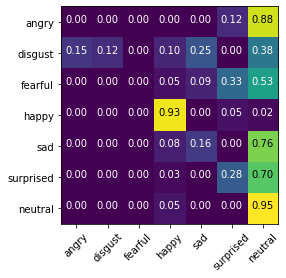

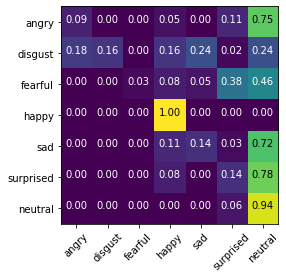

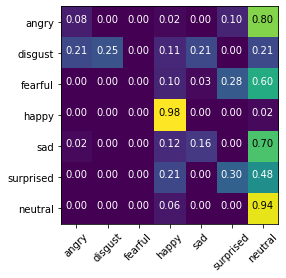

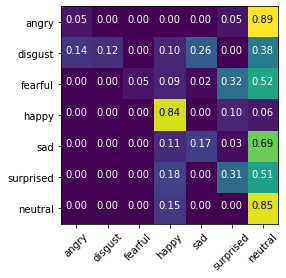

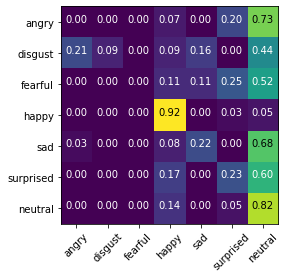

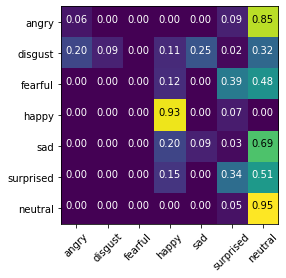

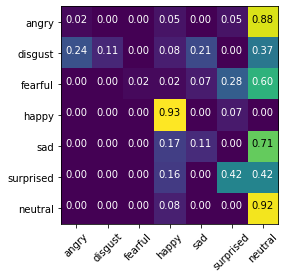

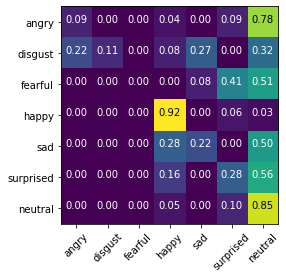

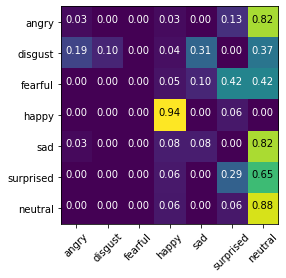

In [15]:
for res in [144, 360, 720]:
    for fps in [5, 15, 30]:
        
        print("---------------------------------------------------------------------------{} p / {} fps".format(res, fps))
        with open("results/ravdess-faces-RN50-vgg-{}-{}-mean.pickle".format(fps, res), "rb") as handle:
            results_dict = pickle.load(handle)

        predictions = results_dict['predictions']
        lb = results_dict['lb']
        actual = results_dict['actual']

        print(classification_report(actual,
            predictions, labels = range(len(lb.classes_)), target_names=lb.classes_, zero_division=0))

        matrix = confusion_matrix(actual, predictions, normalize='true')
        
        plt.figure()
        plt.imshow(matrix, interpolation="nearest")

        target_names = lb.classes_
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)


        thresh = matrix.max() / 1.5
        for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
            plt.text(j, i, "{:0.2f}".format(matrix[i, j]),
                     horizontalalignment="center",
                     color="white" if matrix[i, j] < thresh else "black")

## Classification test
This is a basic test of the classifier - it simply overalys the classifiers predictions over a video in order to check whether the classification matches my perception

In [ ]:
grayscale = True


DATASET = "ravdess-faces"
mean = np.array([123.68, 116.779, 103.939][::1], dtype="float32")

vidlist = glob.glob("../data/dataset/{}/*-30-144.mp4".format(DATASET))

for i, video in enumerate(vidlist):

    vs = cv2.VideoCapture(video)

    # Loop over video frames
    frame_list = []
    while True:
        (grabbed, frame) = vs.read()
        if not grabbed:
            break

        output = frame.copy()
        
        if grayscale:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
        else: 
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
        output = frame
            
        frame = cv2.resize(frame, (197, 197)).astype("float32")
        frame -= 128.8006
        frame /= 64.6497
        frame_list.append(frame)
        
        if len(frame_list) >= 32:
            frames = np.array(frame_list)
            preds = model.predict(np.expand_dims(frames, axis=0))[0]
            frame_list.pop(0)
        

            i = np.argmax(preds)
            preds[i] = 0
            i =  np.argmax(preds)
            label = lb.classes_[i]

            text = "{}".format(label)
            cv2.putText(output, text, (20, 20), cv2.FONT_HERSHEY_SIMPLEX, 1.25, (0, 255, 0), 5)

        cv2.imshow("Output", output)
        key = cv2.waitKey(1) & 0xFF


        # if the `q` key was pressed, break from the loop
        if key == ord("q"):
            break
            
    vs.release()
cv2.destroyWindow('Output')

    

## Image classification results
This section loads the results of our image classification from the server, and displays them as a confusion matrix and classification report.

              precision    recall  f1-score   support

       angry       0.72      0.63      0.67       266
     disgust       0.00      0.00      0.00        15
     fearful       0.89      0.21      0.34        81
       happy       0.88      0.89      0.88       895
         sad       0.66      0.44      0.53       385
   surprised       0.79      0.81      0.80       405
     neutral       0.75      0.90      0.82      1101

    accuracy                           0.78      3148
   macro avg       0.67      0.55      0.58      3148
weighted avg       0.78      0.78      0.77      3148

accuracy : 0.7836721728081322


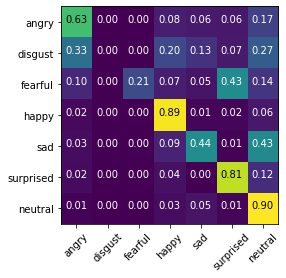

In [5]:
import pickle
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

with open("../../../notebooks/results/my-imagenet-rn50.pickle", "rb") as handle:
    results_dict = pickle.load(handle)

predictions = results_dict['predictions']
lb = results_dict['lb']
actual = results_dict['actual']

print(classification_report(actual,
    predictions, labels = range(len(lb.classes_)), target_names=lb.classes_, zero_division=0))

print("accuracy : {}".format(accuracy_score(actual, predictions)))

matrix = confusion_matrix(actual, predictions, normalize='true')

plt.figure()
plt.imshow(matrix, interpolation="nearest")

target_names = lb.classes_
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)


thresh = matrix.max() / 1.5
for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
    plt.text(j, i, "{:0.2f}".format(matrix[i, j]),
             horizontalalignment="center",
             color="white" if matrix[i, j] < thresh else "black")